CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import model, utils
from utils import train, test

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

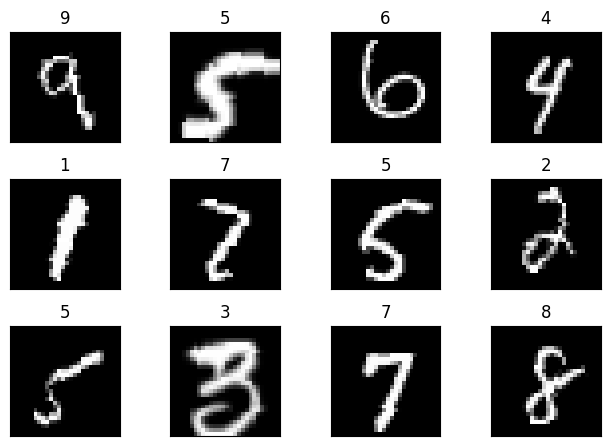

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [8]:
# class Net(nn.Module):
#     #This defines the structure of the NN.
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, bias=False)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, bias=False)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, bias=False)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, bias=False)
#         self.fc1 = nn.Linear(4096, 50, bias=False)
#         self.fc2 = nn.Linear(50, 10, bias=False)

#     def forward(self, x):
#         x = F.relu(self.conv1(x), 2) # 28>26 | 1>3 | 1>1
#         x = F.relu(F.max_pool2d(self.conv2(x), 2)) #26>24>12 | 3>5>6 | 1>1>2
#         x = F.relu(self.conv3(x), 2) # 12>10 | 6>10 | 2>2
#         x = F.relu(F.max_pool2d(self.conv4(x), 2)) # 10>8>4 | 10>14>16 | 2>2>4
#         x = x.view(-1, 4096) # 4*4*256 = 4096
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_summary = model.Net().to(device)
summary(model_summary, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

# from tqdm import tqdm

# def GetCorrectPredCount(pPrediction, pLabels):
#   return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# def train(model, device, train_loader, optimizer, criterion):
#   model.train()
#   pbar = tqdm(train_loader)

#   train_loss = 0
#   correct = 0
#   processed = 0

#   for batch_idx, (data, target) in enumerate(pbar):
#     data, target = data.to(device), target.to(device)
#     optimizer.zero_grad()

#     # Predict
#     pred = model(data)

#     # Calculate loss
#     loss = criterion(pred, target)
#     train_loss+=loss.item()

#     # Backpropagation
#     loss.backward()
#     optimizer.step()
    
#     correct += GetCorrectPredCount(pred, target)
#     processed += len(data)

#     pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
#   train_acc.append(100*correct/processed)
#   train_losses.append(train_loss/len(train_loader))
#   return 

# def test(model, device, test_loader, criterion):
#     model.eval()

#     test_loss = 0
#     correct = 0

#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(test_loader):
#             data, target = data.to(device), target.to(device)

#             output = model(data)
#             test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

#             correct += GetCorrectPredCount(output, target)


#     test_loss /= len(test_loader.dataset)
#     test_acc.append(100. * correct / len(test_loader.dataset))
#     test_losses.append(test_loss)

#     print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [9]:
model = model.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_accuracy, train_loss = train(model, device, train_loader, optimizer, criterion)
  train_acc.append(train_accuracy)
  train_losses.append(train_loss)
  test_accuracy, test_loss = test(model, device, test_loader, criterion)
  test_acc.append(test_accuracy)
  test_losses.append(test_loss)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.5466 Batch_id=117 Accuracy=23.87: 100%|██████████| 118/118 [00:25<00:00,  4.72it/s]


Test set: Average loss: 1.3721, Accuracy: 5192/10000 (51.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2430 Batch_id=117 Accuracy=75.99: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.1341, Accuracy: 9591/10000 (95.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1462 Batch_id=117 Accuracy=95.09: 100%|██████████| 118/118 [00:22<00:00,  5.36it/s]


Test set: Average loss: 0.0725, Accuracy: 9773/10000 (97.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1190 Batch_id=117 Accuracy=96.47: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Test set: Average loss: 0.0567, Accuracy: 9824/10000 (98.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0444 Batch_id=117 Accuracy=97.25: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Test set: Average loss: 0.0461, Accuracy: 9845/10000 (98.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0864 Batch_id=117 Accuracy=97.53: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0400, Accuracy: 9863/10000 (98.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0510 Batch_id=117 Accuracy=97.92: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0388, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0135 Batch_id=117 Accuracy=97.95: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0366, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0203 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0288, Accuracy: 9898/10000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0579 Batch_id=117 Accuracy=98.35: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.0290, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0173 Batch_id=117 Accuracy=98.46: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0276, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0341 Batch_id=117 Accuracy=98.46: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0260, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0295 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0261, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0558 Batch_id=117 Accuracy=98.68: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0255, Accuracy: 9915/10000 (99.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0321 Batch_id=117 Accuracy=98.77: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0226, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0288 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0204, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0139 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0393 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0211, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0046 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0202, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0282 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:23<00:00,  5.13it/s]


Test set: Average loss: 0.0206, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

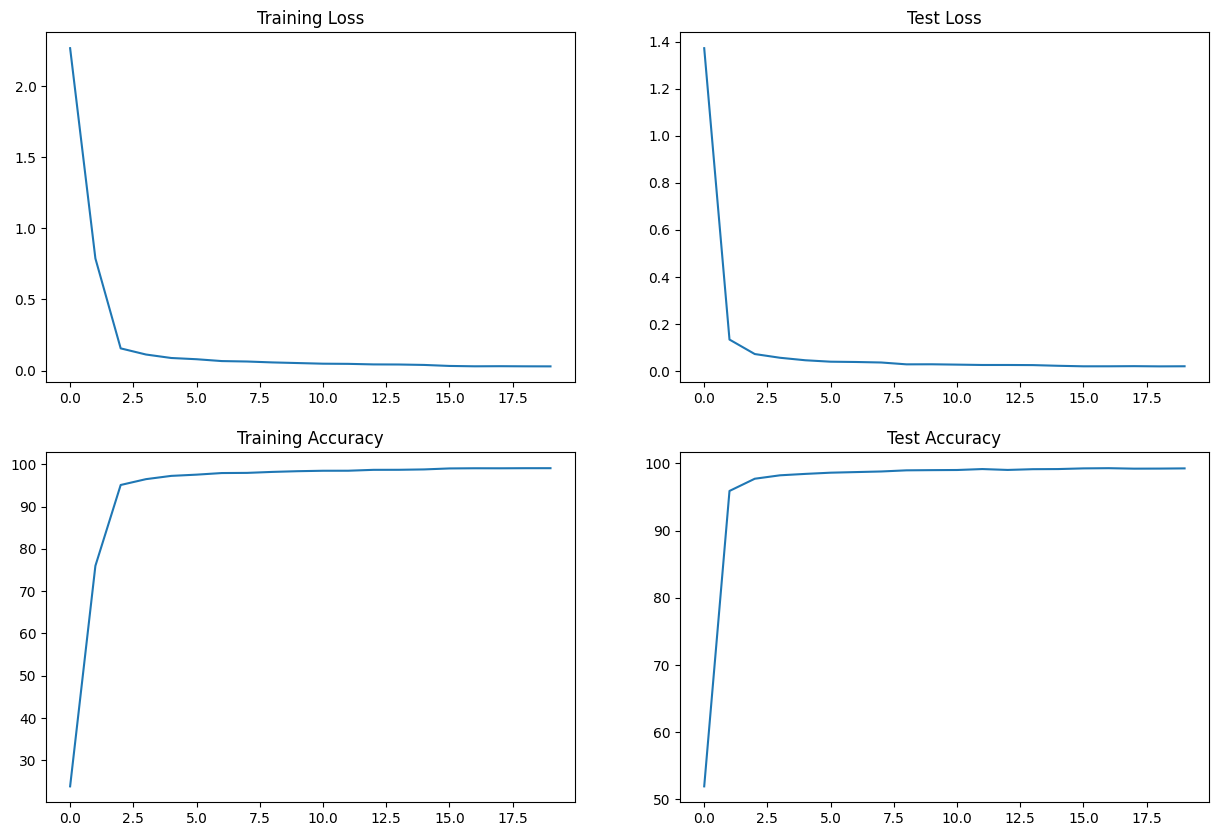

In [10]:
utils.plot_graphs(train_losses,train_acc,test_losses,test_acc)